In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import powerlaw


class london_hashtags:
    def __init__(self,path):
        df = pd.read_csv(path)#,nrows=200000)
        df['date'] = pd.to_datetime(df['date'])
        self.data = df
        
    def print_summary_stats(self):
        print('# hashtag-days:',len(self.data.index))
        print('date range:',self.data['date'].min(),self.data['date'].max())

        s=self.data.groupby(['hashtag'],as_index=False).agg({'count':'sum'}).sort_values('count',ascending=False)
        s.index=range(1,len(s.index)+1)

        sorted_unique_dates = pd.Series(np.sort(self.data['date'].unique()))

        diff=sorted_unique_dates.diff()
        u=pd.Series(diff.unique()).dropna()
        #only two different gap lengths betwen measurements (1 and 2 days)

        print('maximum number of days between measurements:', u.iloc[1]/u.iloc[0])
        print('number of occassions maximum gap occurs:', len(diff[diff==u.iloc[1]]))

        missing_dates = sorted_unique_dates[np.where(diff==u.iloc[1])[0]]

        #sorted_unique_dates[sorted_unique_dates.isin(missing_dates - pd.Timedelta(1,'d'))]
        print('missing dates are: ', [m - pd.Timedelta(1,'d') for m in missing_dates])
        
        
    def derive_turnover_matrix(self,list_size=100,num_increments=21):
        
        def nlargestGroup(df,list_size):
            return (df.nlargest(list_size,'count').
                    assign(rank = lambda df: df['count'].rank(method='first',ascending = False)))

        def turnover(df):
            return len(df[~df['hashtag_today'].isin(df['hashtag_yesterday'])].index)

        def today_yesterday_merge(df):
            return (df.merge(df, left_on=['date','rank'], right_on=['yesterday','rank'], 
                  suffixes = ('_today','_yesterday'),how='inner'))

        def get_turnover_matrix(df,list_size,num_increments):
            turnover_df = pd.DataFrame()
            for ls in np.linspace(1,list_size,num_increments,dtype='int'): 
                turnover_df[ls]=df[df['rank'] <= ls].groupby('date_today').apply(turnover)
            return turnover_df
        
        self.turnover_matrix=(
            self.data.groupby('date',as_index=False).apply(nlargestGroup,list_size).
            assign(yesterday = lambda df: df['date']-pd.Timedelta(1,'d')).
            pipe(today_yesterday_merge).
            pipe(get_turnover_matrix,list_size,num_increments)
        ) 
        
        return self.turnover_matrix
    
    def get_daily_sample_size(self): 
        self.daily_sample_size = self.data.groupby('date').agg({'count':'count'})
        return self.daily_sample_size
    
    def get_all_time_rankings(self): 
        self.all_time_rankings = (self.data.groupby('hashtag').agg({'count':'sum'})['count'].
                                sort_values(descending = True))


In [ ]:

        self.daily_sample_size = self.data.groupby('date').agg({'count':'count'})

In [2]:
path = 'data/hashtagCountsPerDayLondon.csv'

list_size=100
num_increments=21

lh = london_hashtags(path)
lh.print_summary_stats()

#get turnover matrix
turnover = lh.derive_turnover_matrix(list_size,num_increments)
Nt = lh.get_daily_sample_size()

# hashtag-days: 10302088
date range: 2017-01-15 00:00:00 2019-10-15 00:00:00
maximum number of days between measurements: 2.0
number of occassions maximum gap occurs: 2
missing dates are:  [Timestamp('2019-07-11 00:00:00'), Timestamp('2019-09-12 00:00:00')]


In [362]:
def plotaxis_turnover_by_listsize(ax,turnover):
    list_vec = turnover.columns
    mean = turnover.mean()
    error = turnover.std()

    #f, ax = plt.subplots()

    ax.plot(list_vec,mean)
    ax.fill_between(list_vec,mean-error,mean+error,alpha=0.5)
    ax.set_xlabel('list size',fontsize=16)
    ax.set_ylabel('turnover',fontsize=16)
    
    
    return ax

def plotaxis_turnover_by_time(ax,turnover,list_size):

    #HARD WIRED DATE TICKS
    ticks_to_use = pd.Series([pd.to_datetime('2017'),pd.to_datetime('2018'),
                              pd.to_datetime('2019'),pd.to_datetime('2020')])

    labels = ticks_to_use.dt.year

    ax.plot(turnover[list_size],alpha=0.7)

    # Now set the ticks and labels
    ax.set_xticks(ticks_to_use)
    ax.set_xticklabels(labels)

    ax.set_xlabel('year',fontsize=16)
    ax.set_ylabel('turnover (top ' + str(list_size) + ')',fontsize=16)
    
    return ax

def plotaxis_sample_size(ax,Nt):

    #HARD WIRED DATE TICKS
    ticks_to_use = pd.Series([pd.to_datetime('2017'),pd.to_datetime('2018'),
                              pd.to_datetime('2019'),pd.to_datetime('2020')])

    labels = ticks_to_use.dt.year

    ax.plot(Nt.index,Nt,'-')
    ax.set_ylabel('sample size',fontsize=16)
    ax.set_xlabel('year',fontsize=16)
    ax.set_xticks(ticks_to_use)
    ax.set_xticklabels(labels)
    
    return ax

def plotaxis_turnover_by_sample_size(ax,turnover,Nt):

    x=turnover[list_size]
    y=Nt.loc[turnover.index,'count']
    
    lowess = sm.nonparametric.lowess(endog=y, exog=x, frac=0.9)    
    xfit,yfit = list(zip(*lowess))

    ax.plot(x,y,'o',alpha=0.7,label='_legend_')
    ax.plot(xfit,yfit,'-',c='darkred',lw=4,alpha=0.7,label='LOESS fit')
    ax.set_ylabel('sample size',fontsize=16)
    ax.set_xlabel('turnover (top 100)',fontsize=16)
    ax.legend(fontsize=14)
    
    return ax

def plotaxis_powerlaw(ax,x,df):

    def predicted_y(x,fit):
        yfit = x**-fit.alpha
        yfit = yfit/sum(yfit)
        return yfit

    #hashtag counts over all dates
    
    fit=powerlaw.Fit(df,verbose=False)
    
    # power law histogram of hashtags
    x,y = fit.pdf()
    x = x[:-1] + np.diff(x)/2
    y = y/sum(y) #normlize probability density

    #power law line of best fit
    yfit = predicted_y(x,fit)
    
    ax.loglog(x,y,'s',lw=3,label='data hist')
    ax.loglog(x,yfit,'r--',lw=2,label=r'power law fit ($\alpha$= ' + str(np.round(fit.alpha,2)) + ')')

    ax.set_xlabel('hashtag frequency',fontsize=16)
    ax.set_ylabel('probability',fontsize=16)

    ax.legend(fontsize=14)
    
    #self.alpha = fit.alpha
    
    return ax

def plotaxis_daily_powerlawalpha(ax,x,df):

    def calculate_daily_powerlaw(df):
        return powerlaw.Fit(df['count'],verbose=False).alpha

    #calculate the power law exponent for each day
    daily_alpha = df.groupby('date').apply(calculate_daily_powerlaw)

    date_marks = pd.to_datetime(pd.Series(['2017','2018','2019','2020']))
    date_labels = date_marks.dt.year

    ax.plot(daily_alpha)

    ax.set_xticks(date_marks)
    ax.set_xticklabels(date_labels)
    ax.set_ylabel(r'$\alpha$',fontsize=20,rotation=0)
    ax.set_xlabel('year',fontsize=16)

    return ax

In [364]:
df = 

In [369]:
df

hashtag
London                     371726
london                     243137
trndnl                     146276
job                        119509
free                        87801
                            ...  
fenixhour                       1
fenixtour                       1
fenlandairporttransfers         1
fenlandarts                     1
0000FF                          1
Name: count, Length: 2300866, dtype: int64

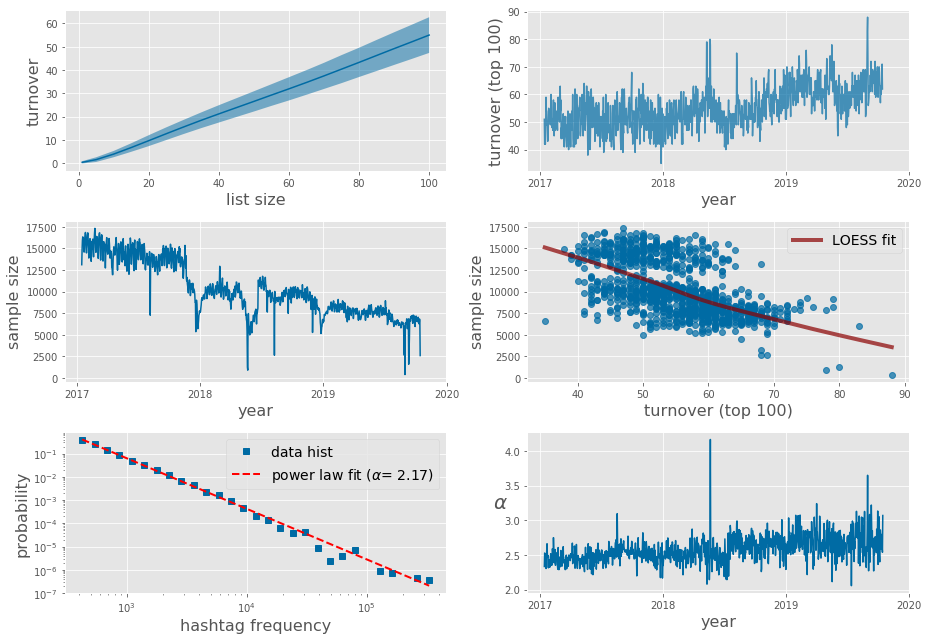

In [363]:
plt.style.use('tableau-colorblind10')

f, ax = plt.subplots(3,2,figsize=[13,9])

plotaxis_turnover_by_listsize(ax[0,0],turnover)
plotaxis_turnover_by_time(ax[0,1],turnover,list_size)
plotaxis_turnover_by_sample_size(ax[1,0],turnover,Nt)
plotaxis_sample_size(ax[1,1],Nt)
plotaxis_powerlaw(ax[2,0],x,lh.data)
plotaxis_daily_powerlawalpha(ax[2,1],x,df)


plt.tight_layout()

In [108]:
df = pd.read_csv(path)#,nrows=800000)
df['date'] = pd.to_datetime(df['date'])